In [1]:
import pandas as pd
from sklearn import datasets
dataset = pd.read_csv("beer.txt")

In [2]:
dataset.head()

,calorific_value,nitrogen,turbidity,style,alcohol,sugars,bitterness,beer_id,colour,degree_of_fermentation
0,41.721239,0.503276,2.628182,ale,4.015385,16.73,10.452789,93,13.44,55.337143
1,42.429204,0.525512,1.776364,ale,4.092308,16.72,10.999526,103,12.24,58.380000
2,45.880531,0.443233,2.628182,ale,4.276923,16.68,13.456368,178,10.92,58.382857
3,45.305310,0.471668,1.806364,ale,4.126154,18.84,9.202737,166,10.92,58.525714
4,38.977876,0.392846,2.272727,ale,4.015385,16.77,9.457895,44,10.56,58.900000


In [3]:
df0 = dataset.loc[dataset['style'] == "ale"]
df1 = dataset.loc[dataset['style'] == "lager"]
df2 = dataset.loc[dataset['style'] == "stout"]

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
dataset.drop(['style'], axis='columns')

,calorific_value,nitrogen,turbidity,alcohol,sugars,bitterness,beer_id,colour,degree_of_fermentation
0,41.721239,0.503276,2.628182,4.015385,16.73,10.452789,93,13.44,55.337143
1,42.429204,0.525512,1.776364,4.092308,16.72,10.999526,103,12.24,58.380000
2,45.880531,0.443233,2.628182,4.276923,16.68,13.456368,178,10.92,58.382857
3,45.305310,0.471668,1.806364,4.126154,18.84,9.202737,166,10.92,58.525714
4,38.977876,0.392846,2.272727,4.015385,16.77,9.457895,44,10.56,58.900000
...,...,...,...,...,...,...,...,...,...
149,39.951327,0.272587,5.217273,4.412308,16.68,6.008368,54,6.84,74.757143
150,40.039823,0.347919,2.859091,4.178462,17.58,7.340842,56,8.88,74.887143
151,43.977876,0.266770,3.775455,4.347692,19.10,7.356000,132,7.32,75.894286
152,45.349558,0.255530,1.301818,4.160000,18.17,3.243579,169,10.68,76.182857


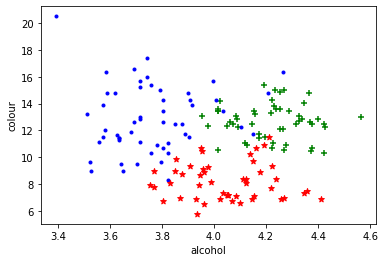

In [5]:
plt.xlabel('alcohol')
plt.ylabel('colour')
plt.scatter(df0['alcohol'], df0['colour'],color="green",marker='+')
plt.scatter(df1['alcohol'], df1['colour'],color="blue",marker='.')
plt.scatter(df2['alcohol'], df2['colour'],color="red",marker='*')

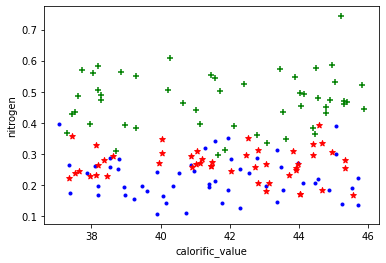

In [6]:
plt.xlabel('calorific_value')
plt.ylabel('nitrogen')
plt.scatter(df0['calorific_value'], df0['nitrogen'],color="green",marker='+')
plt.scatter(df1['calorific_value'], df1['nitrogen'],color="blue",marker='.')
plt.scatter(df2['calorific_value'], df2['nitrogen'],color="red",marker='*')

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = dataset.drop(['style'], axis='columns')
y = dataset['style']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1/3))

In [10]:
len(X_train)


102

In [11]:
len(X_test)


52

In [12]:
import numpy as np
import sklearn

In [13]:
#Picking SVM as small data sets and high dimensionaldata
from sklearn.svm import SVC

In [17]:
#OVO as only 3 classes
model_linear_kernal = SVC(kernel='linear', decision_function_shape = 'ovo')
model_linear_kernal.fit(X_train, y_train)
model_linear_kernal

SVC(decision_function_shape='ovo', kernel='linear')

In [18]:
accuracy = model_linear_kernal.score(X_test, y_test)
accuracy

0.8653846153846154

In [ ]:
cm_lin = sklearn.metrics.confusion_matrix(y_test, model_linear_kernal)

In [24]:
import numpy as np

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder


def projection_simplex(v, z=1):
    """
    Projection onto the simplex:
        w^* = argmin_w 0.5 ||w-v||^2 s.t. \sum_i w_i = z, w_i >= 0
    """
    # For other algorithms computing the same projection, see
    # https://gist.github.com/mblondel/6f3b7aaad90606b98f71
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


class MulticlassSVM(BaseEstimator, ClassifierMixin):

    def __init__(self, C=1, max_iter=50, tol=0.05,
                 random_state=None, verbose=0):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol,
        self.random_state = random_state
        self.verbose = verbose

    def _partial_gradient(self, X, y, i):
        # Partial gradient for the ith sample.
        g = np.dot(X[i], self.coef_.T) + 1
        g[y[i]] -= 1
        return g

    def _violation(self, g, y, i):
        # Optimality violation for the ith sample.
        smallest = np.inf
        for k in range(g.shape[0]):
            if k == y[i] and self.dual_coef_[k, i] >= self.C:
                continue
            elif k != y[i] and self.dual_coef_[k, i] >= 0:
                continue

            smallest = min(smallest, g[k])

        return g.max() - smallest

    def _solve_subproblem(self, g, y, norms, i):
        # Prepare inputs to the projection.
        Ci = np.zeros(g.shape[0])
        Ci[y[i]] = self.C
        beta_hat = norms[i] * (Ci - self.dual_coef_[:, i]) + g / norms[i]
        z = self.C * norms[i]

        # Compute projection onto the simplex.
        beta = projection_simplex(beta_hat, z)

        return Ci - self.dual_coef_[:, i] - beta / norms[i]

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Normalize labels.
        self._label_encoder = LabelEncoder()
        y = self._label_encoder.fit_transform(y)

        # Initialize primal and dual coefficients.
        n_classes = len(self._label_encoder.classes_)
        self.dual_coef_ = np.zeros((n_classes, n_samples), dtype=np.float64)
        self.coef_ = np.zeros((n_classes, n_features))

        # Pre-compute norms.
        norms = np.sqrt(np.sum(X ** 2, axis=1))

        # Shuffle sample indices.
        rs = check_random_state(self.random_state)
        ind = np.arange(n_samples)
        rs.shuffle(ind)

        violation_init = None
        for it in range(self.max_iter):
            violation_sum = 0

            for ii in range(n_samples):
                i = ind[ii]

                # All-zero samples can be safely ignored.
                if norms[i] == 0:
                    continue

                g = self._partial_gradient(X, y, i)
                v = self._violation(g, y, i)
                violation_sum += v

                if v < 1e-12:
                    continue

                # Solve subproblem for the ith sample.
                delta = self._solve_subproblem(g, y, norms, i)

                # Update primal and dual coefficients.
                self.coef_ += (delta * X[i][:, np.newaxis]).T
                self.dual_coef_[:, i] += delta

            if it == 0:
                violation_init = violation_sum

            vratio = violation_sum / violation_init

            #if self.verbose >= 1:
                #print("iter", it + 1, "violation", vratio)

            if vratio < self.tol:
                if self.verbose >= 1:
                    print("Converged")
                break

        return self

    def predict(self, X):
        decision = np.dot(X, self.coef_.T)
        pred = decision.argmax(axis=1)
        return self._label_encoder.inverse_transform(pred)



In [37]:
import pandas

x_df=X_train.to_numpy()
y_df=y_train.to_numpy()

In [38]:
clf = MulticlassSVM(C=1, tol=0.05, max_iter=1000, random_state=0, verbose=1)
clf.fit(x_df, y_df)

print(clf.score(x_df, y_df))


0.7450980392156863


In [39]:
x_dft=X_test.to_numpy()
y_dft=y_test.to_numpy()

In [40]:
print(clf.score(x_dft, y_dft))


0.7692307692307693
